In [12]:
import pandas as pd
import numpy as np
import plotly.express as px
import pymc3 as pm
import arviz as az
from einops import rearrange

### Data reading and cleaning

Data preparation includes period start and end dates calculation, averaging water usage calculation etc.

In [21]:
df = pd.read_csv(
    'asd.csv',
    parse_dates=['date'],
    infer_datetime_format=True
)[::-1]

df = df.rename(columns={
    'date': 'period_end_date'
})

df['period_start_date'] = np.nan
df['period_start_date'] = df['period_start_date'].astype('datetime64[ns]')
df.iloc[1:, df.columns.get_loc('period_start_date')] = df.iloc[:-1, df.columns.get_loc('period_end_date')]

df['water_usage'] = df['water_meter'].diff()
df['period_length'] = df['period_end_date'] - df['period_start_date']
df['avg_water_usage_per_day'] = df['water_usage'] / df['period_length'].dt.days

# Remove first period without known usage
df = df.iloc[1:, :] \
    .reset_index(drop=True)

# Reorder columns
df = df[[
    'period_start_date',
    'period_end_date',
    'period_length',
    'water_usage',
    'avg_water_usage_per_day'
]]

Prepared data frame looks as below:

In [22]:
df.head()

,period_start_date,period_end_date,period_length,water_usage,avg_water_usage_per_day
0,2021-05-11,2021-05-26,15 days,4.819,0.321267
1,2021-05-26,2021-06-16,21 days,3.096,0.147429
2,2021-06-16,2021-06-23,7 days,3.595,0.513571
3,2021-06-23,2021-06-24,1 days,0.313,0.313000
4,2021-06-24,2021-07-08,14 days,6.455,0.461071


It would be helpful to look how the water usage looks in the whole period

In [23]:
px.line(
    df,
    x='period_start_date',
    y='avg_water_usage_per_day',
    line_shape='hv',
    title='Water usage during the whole period',
    labels={
         "period_start_date": "time",
         "avg_water_usage_per_day": "average water usage per day (m³)",
    }
)

In [51]:
expanded_water_usage_per_day = df \
    .apply(lambda row: [row['avg_water_usage_per_day']] * row['period_length'].days, axis=1) \
    .explode() \
    .astype(np.float)

In [66]:
from scipy.stats import norm
import plotly.graph_objects as go

mu, std = norm.fit(expanded_water_usage_per_day)

xmin, xmax = expanded_water_usage_per_day.min(), expanded_water_usage_per_day.max()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)

fig = px.histogram(
    expanded_water_usage_per_day,
    histnorm='probability density',
)
fig
fig.add_traces(go.Scatter(x=x, y=p, mode = 'lines',
                          name = 'normal'
                         ))

In [6]:
with pm.Model() as simple_model:
    # Priors
    mu = pm.TruncatedNormal("mu", mu=0.3, sd=0.2, lower=0)

    # Likelihood
    pm.Normal("water_usage_per_day", mu=mu, observed=df['expanded_water_usage_per_day'].explode())

### Sampling

In [7]:
with simple_model:
    idata = pm.sample(4000, tune=4000, return_inferencedata=True)

    posterior_predictive = pm.sample_posterior_predictive(idata)
    idata_aux = az.from_pymc3(posterior_predictive=posterior_predictive)
    idata.extend(idata_aux)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


Sampling 4 chains for 4_000 tune and 4_000 draw iterations (16_000 + 16_000 draws total) took 10 seconds.


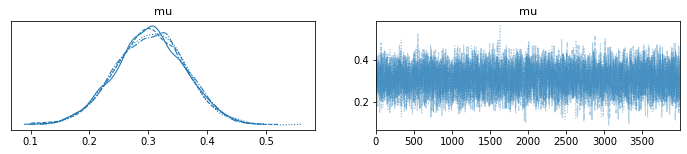

In [15]:
with simple_model:
    az.plot_trace(idata);

In [98]:
def predict_usage_for_days(days, idata):
    samples = rearrange(idata.posterior['mu'].values, 'chain draw -> (chain draw)')

    rows = len(samples) // days
    p = samples[:days*rows] \
            .reshape((rows, days)) \
            .sum(axis=1)

    az.plot_posterior(p)

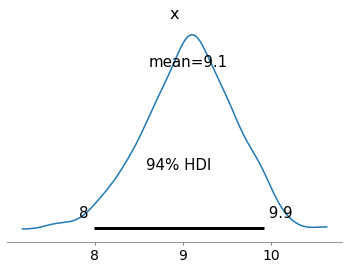

In [9]:
predict_usage_for_days(30, idata)

### Standard deviation correction

The fact is that we do not observe the water usage in each day, but we observe the average water usage within periods with varying lengths!

Assuming daily water usage is normally distributed then the observed averaged usage is also normally distributed, but with smaller standard deviation. Formally, if $d_{i}$ is water usage in day number $i$ and
$$d_{i} \sim \mathcal{N}(\mu,\,\sigma^{2})$$
then
$$\overline{d} \sim \mathcal{N}(\mu,\,\frac{\sigma^{2}}{n})$$
where
$$\overline{d} = \frac{1}{n} \sum_{i=1}^{n} d_{i}\,.$$

Thus, standard deviation of the likelihood should be corrected by dividing it by $\sqrt{n}$ where $n$ is the length of the period.

Model `sd_corrected_model` defined below implements the observation.

In [182]:
with pm.Model() as sd_corrected_model:
    # Data
    period_lengths = pm.Data("period_lengths", df['period_length'].dt.days)
    usage = pm.Data("usage", df['avg_water_usage_per_day'])

    # Priors
    mu = pm.TruncatedNormal("mu", mu=0.3, sd=0.2, lower=0)
    sd = pm.Gamma("sd", mu=0.1, sd=0.05)

    # Likelihood
    pm.Normal(
        f"water_usage_per_day",
        mu=mu,
        sd=sd / np.sqrt(period_lengths),
        observed=usage
    )

In [183]:
with sd_corrected_model:
    idata = pm.sample(2000, tune=4000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mu]


Sampling 4 chains for 4_000 tune and 2_000 draw iterations (16_000 + 8_000 draws total) took 5 seconds.


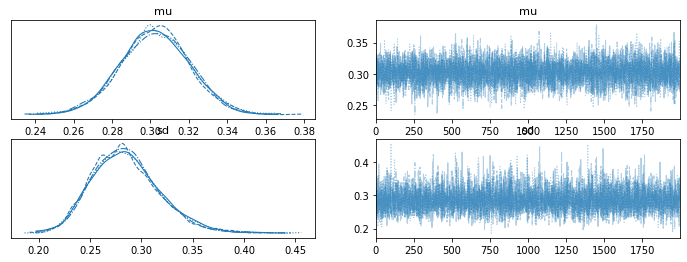

In [184]:
with sd_corrected_model:
    az.plot_trace(idata);

Estimated `sd` is pretty big, so it shows that the water usage vary a lot from day to day.

#### Prediction
Let's now predict water usage for next 30 days.

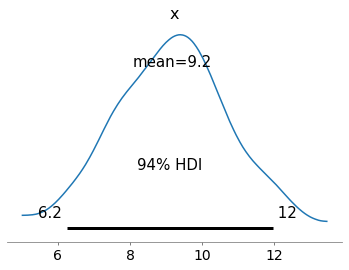

In [185]:
with sd_corrected_model:
    pm.set_data({'period_lengths': [1], 'usage': []})

    posterior_predictive = pm.sample_posterior_predictive(idata, var_names=['water_usage_per_day'])

days = 30

rows = len(posterior_predictive['water_usage_per_day']) // days
samples = posterior_predictive['water_usage_per_day'][:days*rows] \
        .reshape((rows, days)) \
        .sum(axis=1)

az.plot_posterior(samples);

## Dirichlet model

In [ ]:
with pm.Model() as mixture_model:
    hh = pm.Dirichlet("hh", a=np.array([8, 1, 1]))

    mu_normal = pm.TruncatedNormal("mu_normal", mu=0.3, sd=0.2, lower=0)
    mu_guests = pm.TruncatedNormal("mu_guests", mu=0.6, sd=0.2, lower=0)
    mu_vacation = pm.TruncatedNormal("mu_vacation", mu=0.0, sd=0.2, lower=0)

    # obs = pm.Mixture("obs", hh, [pm.Normal.dist(mu=mu_normal), pm.Normal.dist(mu=mu_guests), pm.Normal.dist(mu=mu_vacation)], observed=df['expanded_water_usage_per_day'].explode())

    obs = pm.NormalMixture(
        "obs",
        w=hh,
        mu=[mu_normal, mu_guests, mu_vacation],
        observed=df['expanded_water_usage_per_day'].explode()
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vacation, mu_guests, mu_normal, hh]


Sampling 4 chains for 4_000 tune and 4_000 draw iterations (16_000 + 16_000 draws total) took 28 seconds.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.


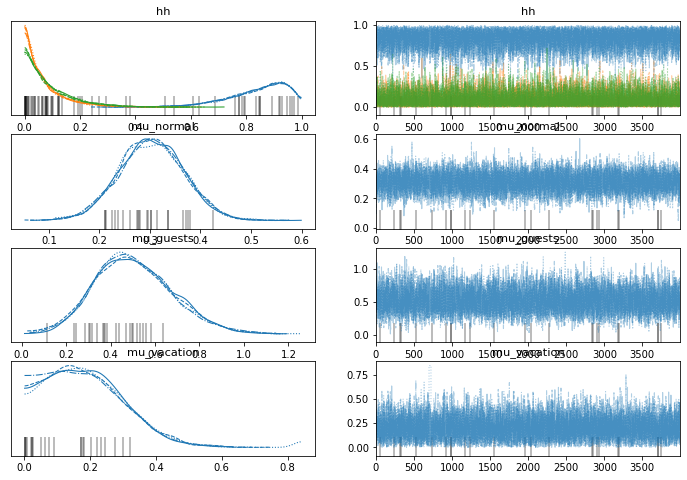

In [11]:
with mixture_model:
    idata = pm.sample(4000, tune=4000, return_inferencedata=True)
    az.plot_trace(idata);

In [29]:
with mixture_model:
    posterior_predictive = pm.sample_posterior_predictive(idata)
    idata_aux = az.from_pymc3(posterior_predictive=posterior_predictive)
    idata.extend(idata_aux)